# FIN7850 Alpha Factor Trading Strategy Trading Strategy

## 1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import yfinance as yf

sns.set(rc={'figure.figsize':(15,10)})
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2-1. Finding training dataset

In [2]:
# get stock data from yfinance
data = yf.download('AAPL', start='2016-01-02', end='2021-2-22')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.364536,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.753977,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.289116,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.306208,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.424154,283192000
...,...,...,...,...,...,...
2021-02-12,134.350006,135.529999,133.690002,135.369995,135.369995,60029300
2021-02-16,135.490005,136.009995,132.789993,133.190002,133.190002,80206200
2021-02-17,131.250000,132.220001,129.470001,130.839996,130.839996,97918500


In [3]:
#get stocks' adjust close price
price = data['Adj Close']
price

Date
2016-01-04     24.364536
2016-01-05     23.753977
2016-01-06     23.289116
2016-01-07     22.306208
2016-01-08     22.424154
                 ...    
2021-02-12    135.369995
2021-02-16    133.190002
2021-02-17    130.839996
2021-02-18    129.710007
2021-02-19    129.869995
Name: Adj Close, Length: 1292, dtype: float64

## 2-2. Exploratory data analysis

Text(0.5, 1.0, 'Apple Stock Price')

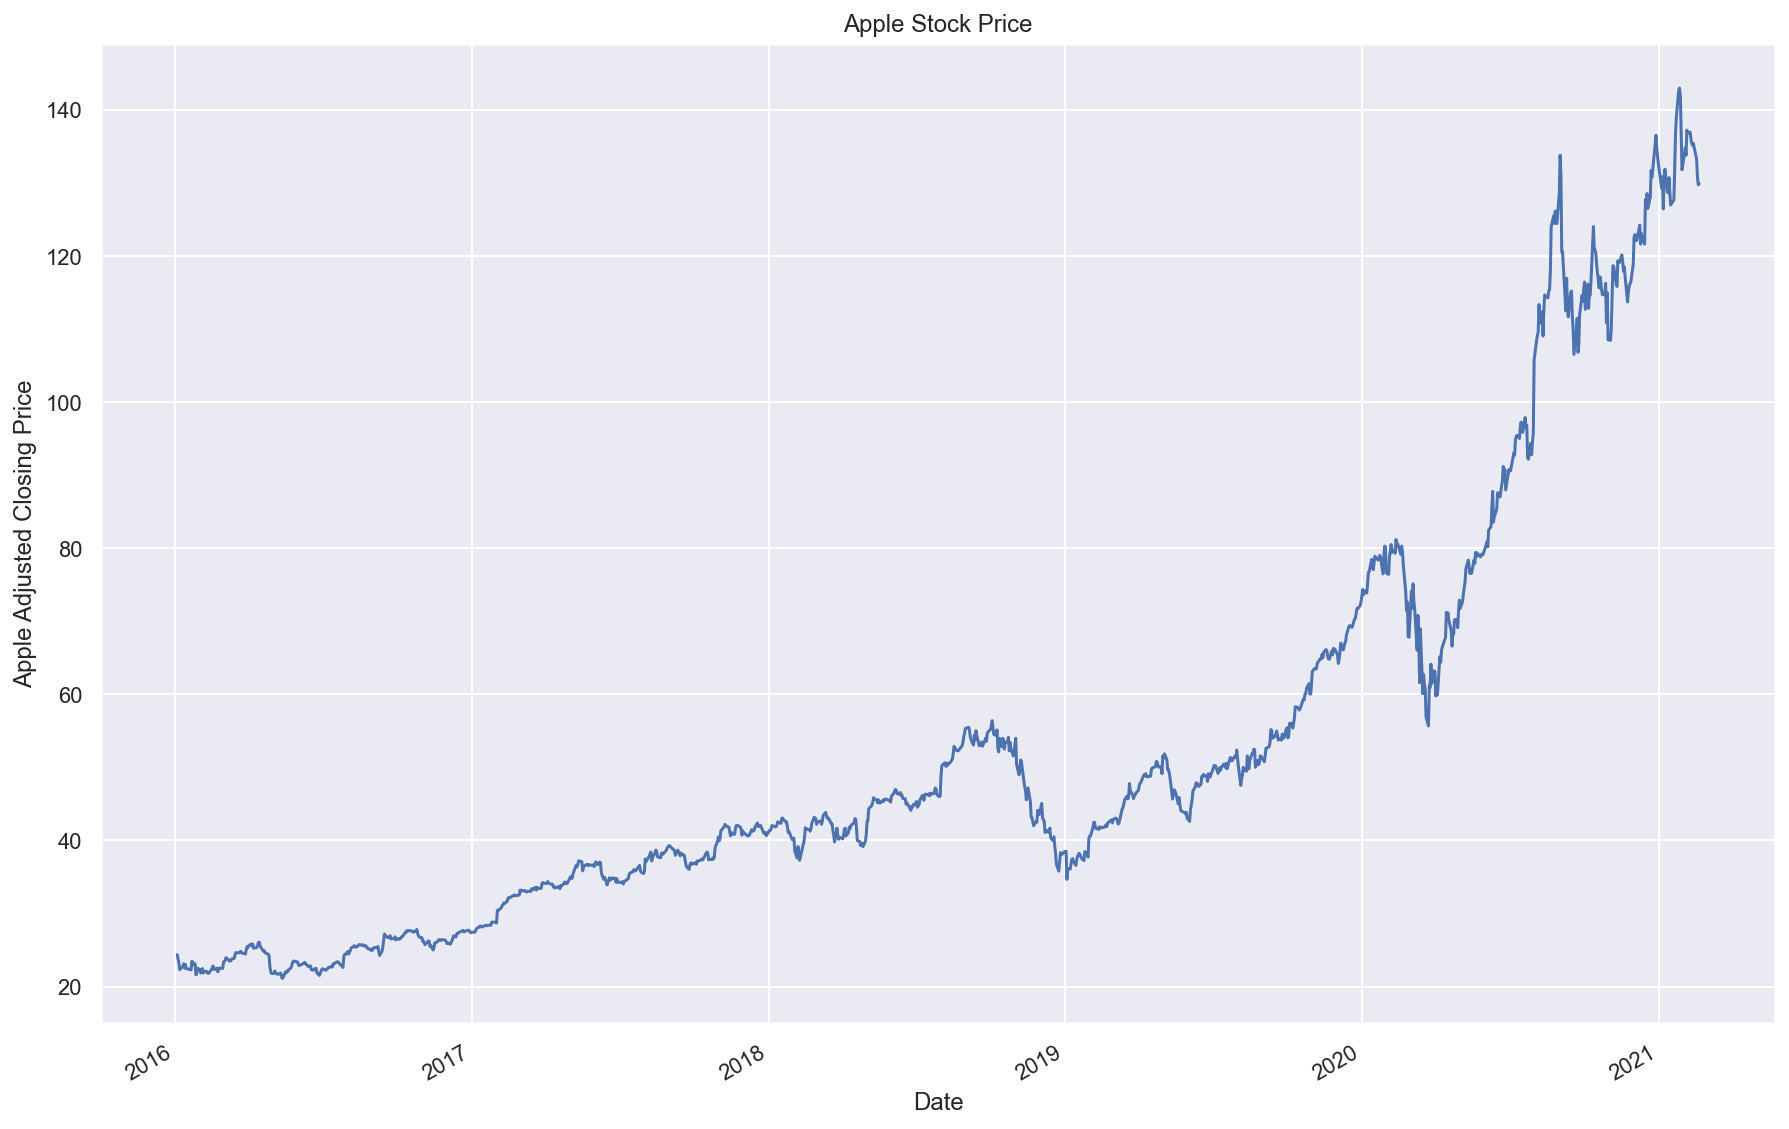

In [4]:
# plot the adjusted closing price
price.plot()
plt.ylabel('Apple Adjusted Closing Price')
plt.xlabel('Date')
plt.title('Apple Stock Price')

count    1291.000000
mean        0.001478
std         0.019019
min        -0.128647
25%        -0.006013
50%         0.001009
75%         0.010160
max         0.119808
Name: Adj Close, dtype: float64


<AxesSubplot:>

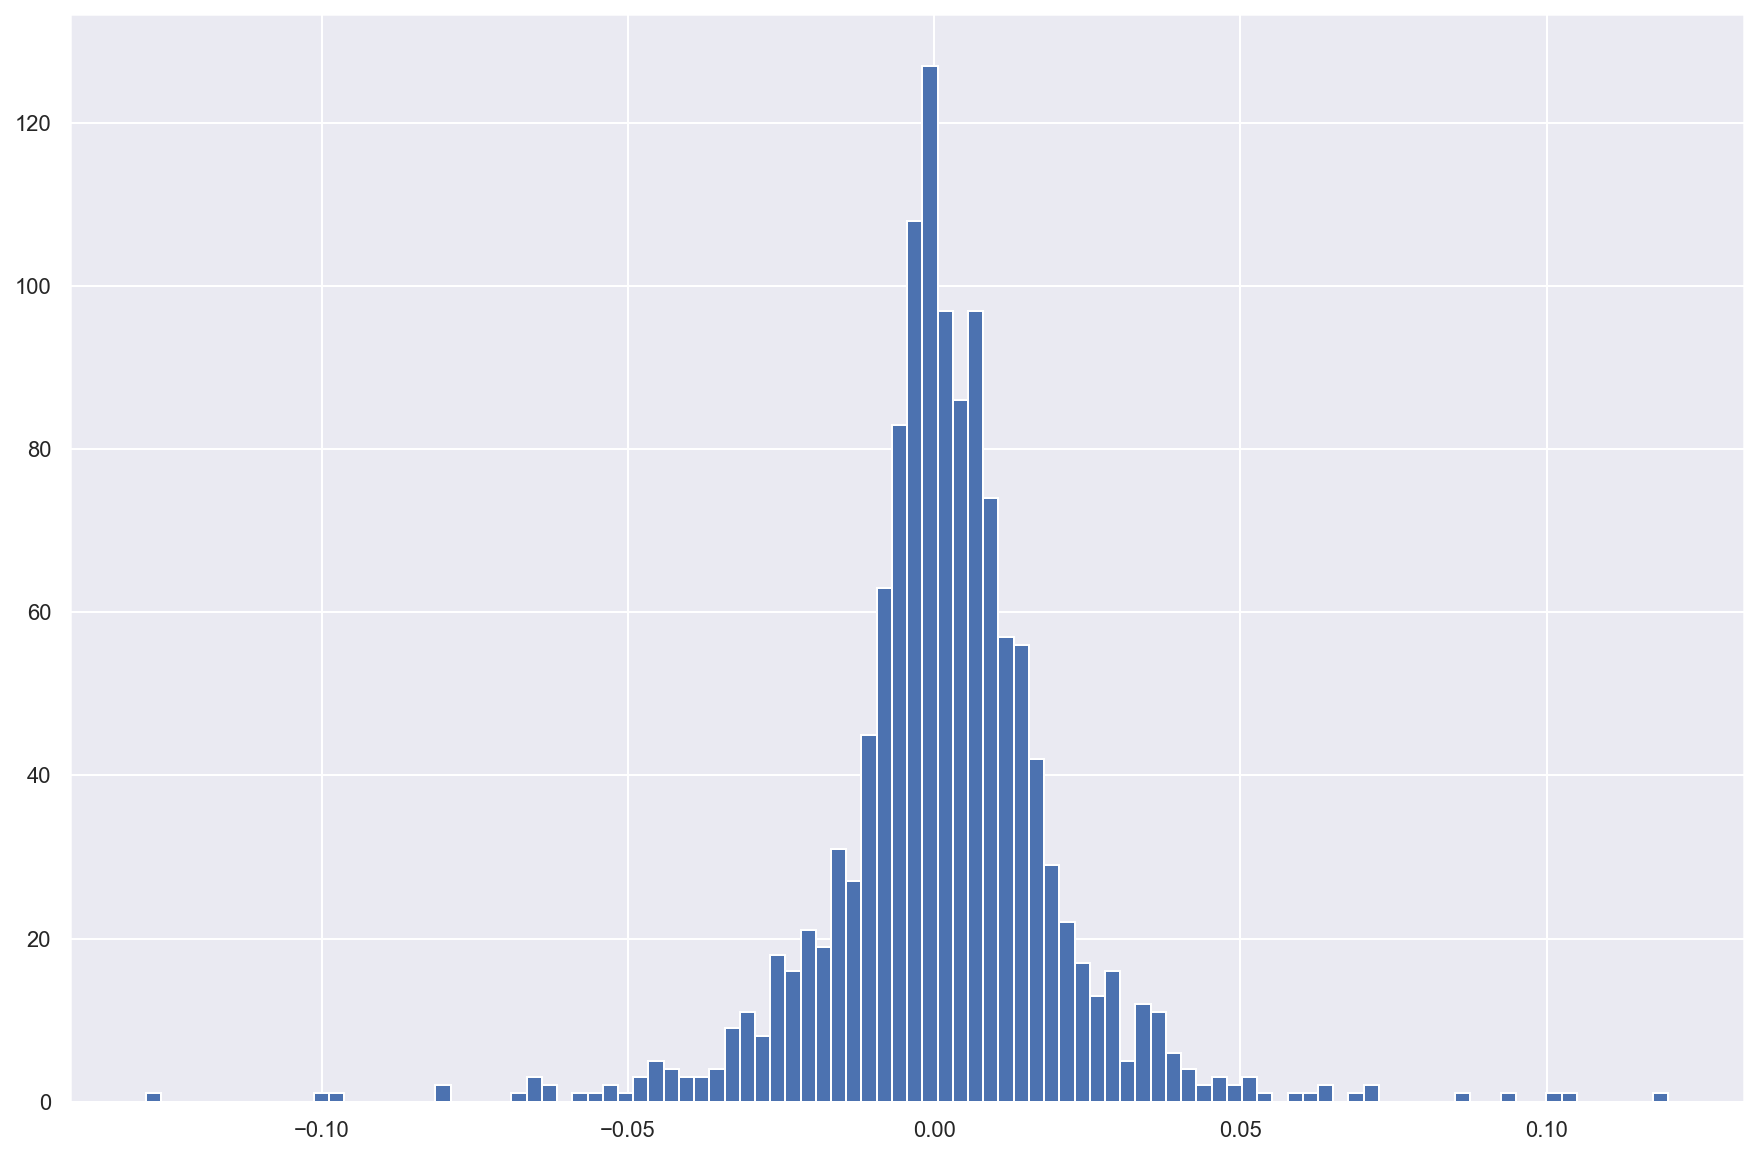

In [5]:
# look at price volatility (adjusted closing price) summary statistics
print(price.pct_change().describe())
price.pct_change().hist(bins=100)

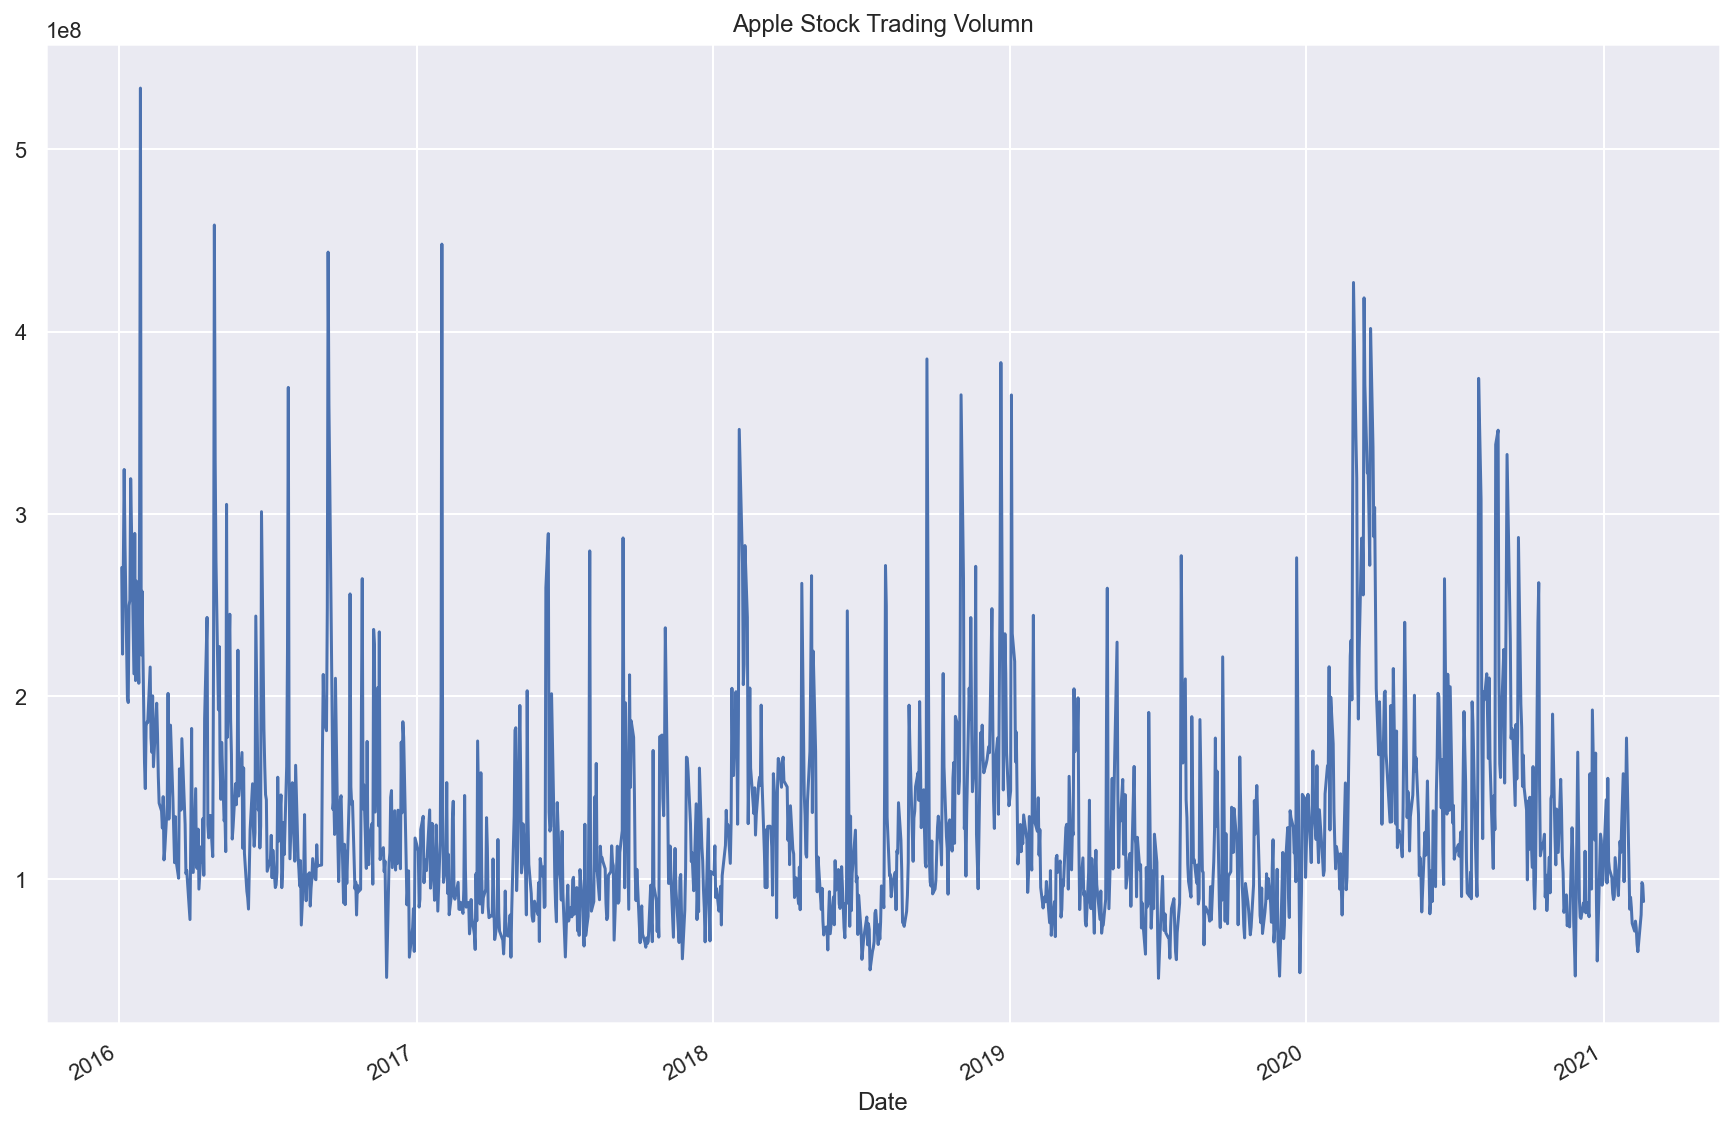

In [6]:
# check the daily trading volumn
data["Volume"].plot()
plt.title('Apple Stock Trading Volumn')
plt.xlabel('Date')
plt.show()

Text(0.5, 1.0, 'Moving Average of 10,40,120 days of Apple stock price')

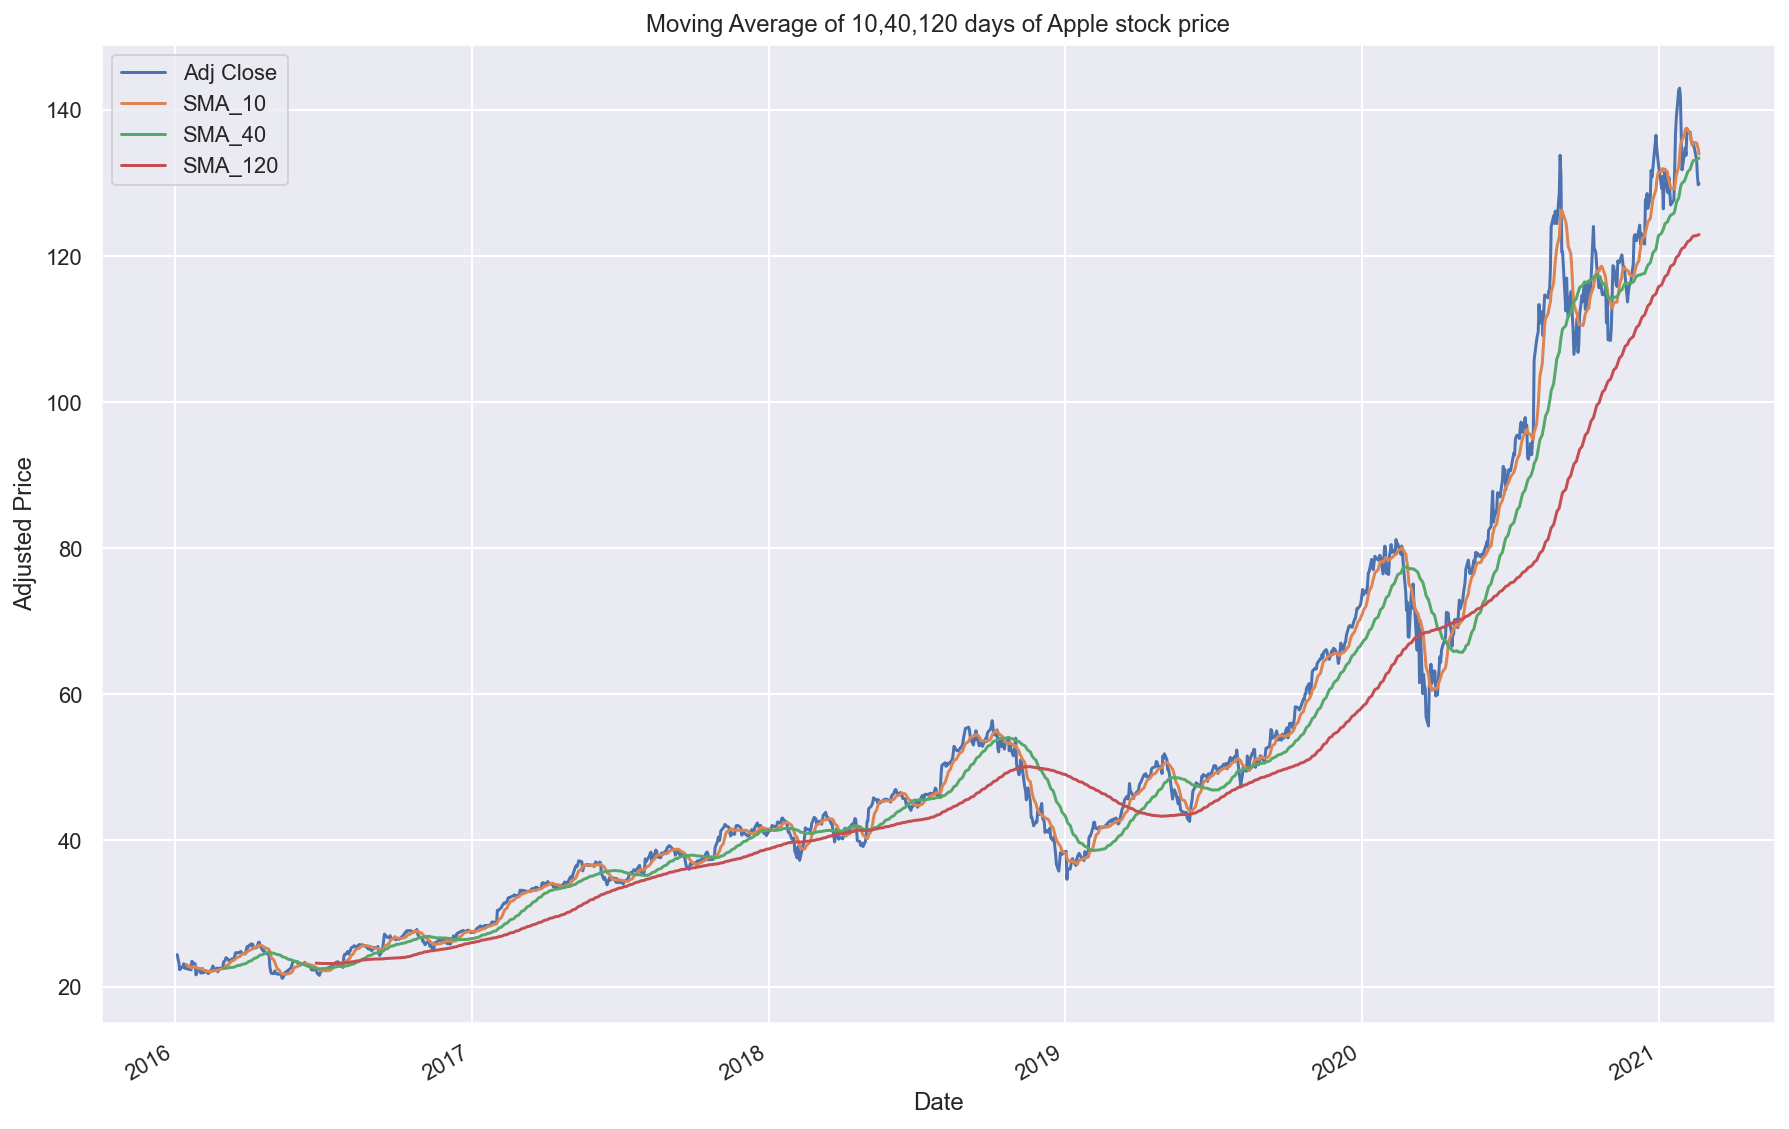

In [7]:
# use pandas in-bulit rolling function to get moving average price
data['SMA_10'] = price.rolling(window=10).mean()
data['SMA_40'] = price.rolling(window=40).mean()
data['SMA_120'] = price.rolling(window=120).mean()

# plot the moving average line with the adjusted closing price
data[['Adj Close','SMA_10','SMA_40','SMA_120']].plot()
plt.ylabel('Adjusted Price')
plt.title('Moving Average of 10,40,120 days of Apple stock price')

## 3. Alpha Factor Trading model

## 3-1. Data preprocessing

In [8]:
col_drop=['SMA_10','SMA_40','SMA_120']
data.drop(columns=col_drop,inplace=True)

# calculate the return rate of each day from the day before
data['Return'] = np.log(data['Adj Close'] / data['Adj Close'].shift())
data.dropna(inplace=True)

# define y as the positive return rate and it is the target column
data['Target'] = (data['Return']>0).astype(int)
data

,Open,High,Low,Close,Adj Close,Volume,Return,Target
Date,,,,,,,,
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.753977,223164000,-0.025379,0
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.289116,273829600,-0.019764,0
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.306208,324377600,-0.043121,0
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.424154,283192000,0.005274,1
2016-01-11,24.742500,24.764999,24.334999,24.632500,22.787258,198957600,0.016063,1
...,...,...,...,...,...,...,...,...
2021-02-12,134.350006,135.529999,133.690002,135.369995,135.369995,60029300,0.001774,1
2021-02-16,135.490005,136.009995,132.789993,133.190002,133.190002,80206200,-0.016235,0
2021-02-17,131.250000,132.220001,129.470001,130.839996,130.839996,97918500,-0.017802,0


In [9]:
# split the 'data' dataset with training and testing
data_train = data.loc[:'2020-2-3'].shift().dropna()
data_test = data.loc['2020-2-3':].shift().dropna()

# shift the dataset for 1 row using the former day data
# to predict the next day's data and set it as X
X = data.loc[:]
# split the 'X' dataset with training and testing
X_train = data_train.loc[:'2020-2-3',:'Volume']
X_test = data_test.loc['2020-2-3':,:'Volume']

# split the 'y' dataset with training and testing
y = data['Target'].dropna()
y_train = data_train['Target'].loc[:'2020-2-3']
y_test = data_test['Target'].loc['2020-2-3':]

print(X_train.shape, X_test.shape,
      y_train.shape, y_test.shape,
      data_train.shape, data_test.shape)

(1026, 6) (264, 6) (1026,) (264,) (1026, 8) (264, 8)


### In the dataset we define the positive return will lead to value of 1 in target column. It means that the stock rise in the day so we decide to buy in and sell it out if that day's price is dropped. 

## 3-2. Trading with conventional strategy

Text(0.5, 1.0, 'Conventional Trading Result')

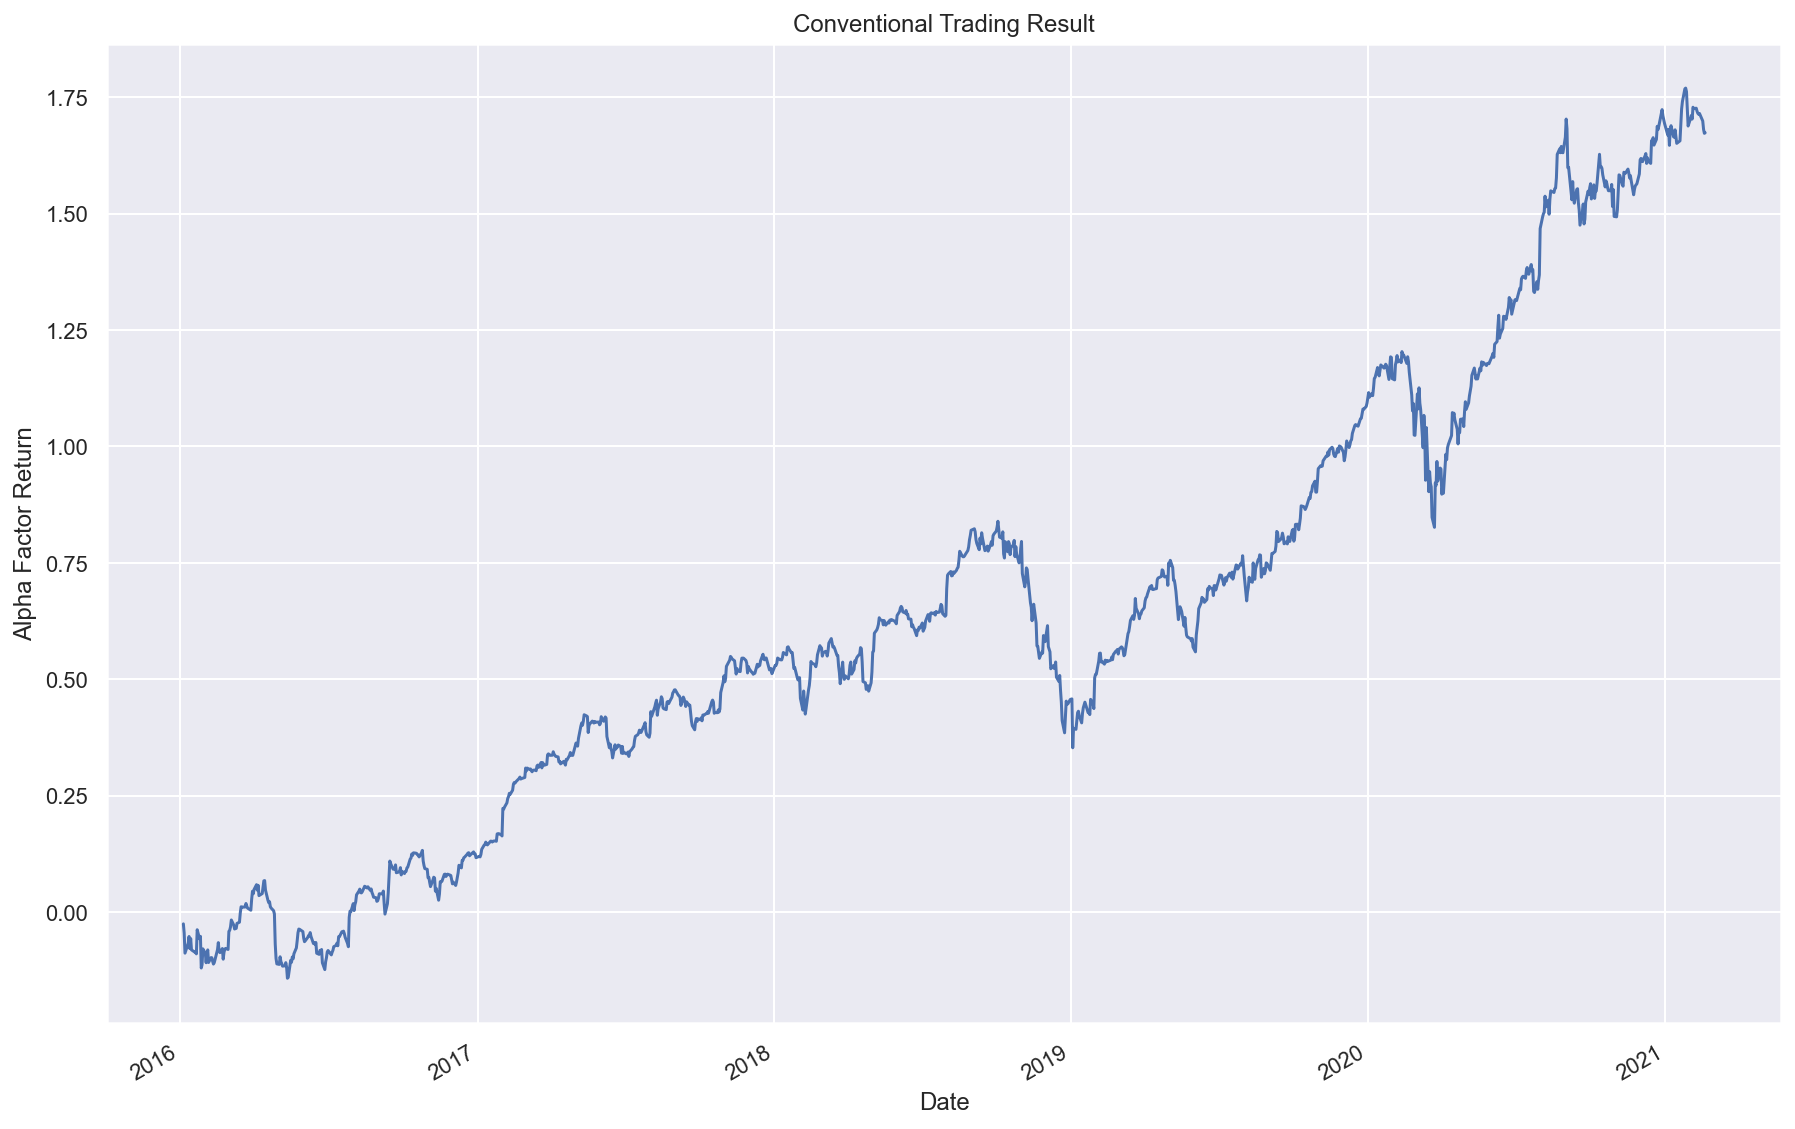

In [10]:
# plot the line of return in doing nothing in strategy for comparison 
data['Return'].cumsum().plot()
plt.ylabel('Alpha Factor Return')
plt.title('Conventional Trading Result')

Text(0.5, 1.0, 'Actual Alpha Factor Trading Result')

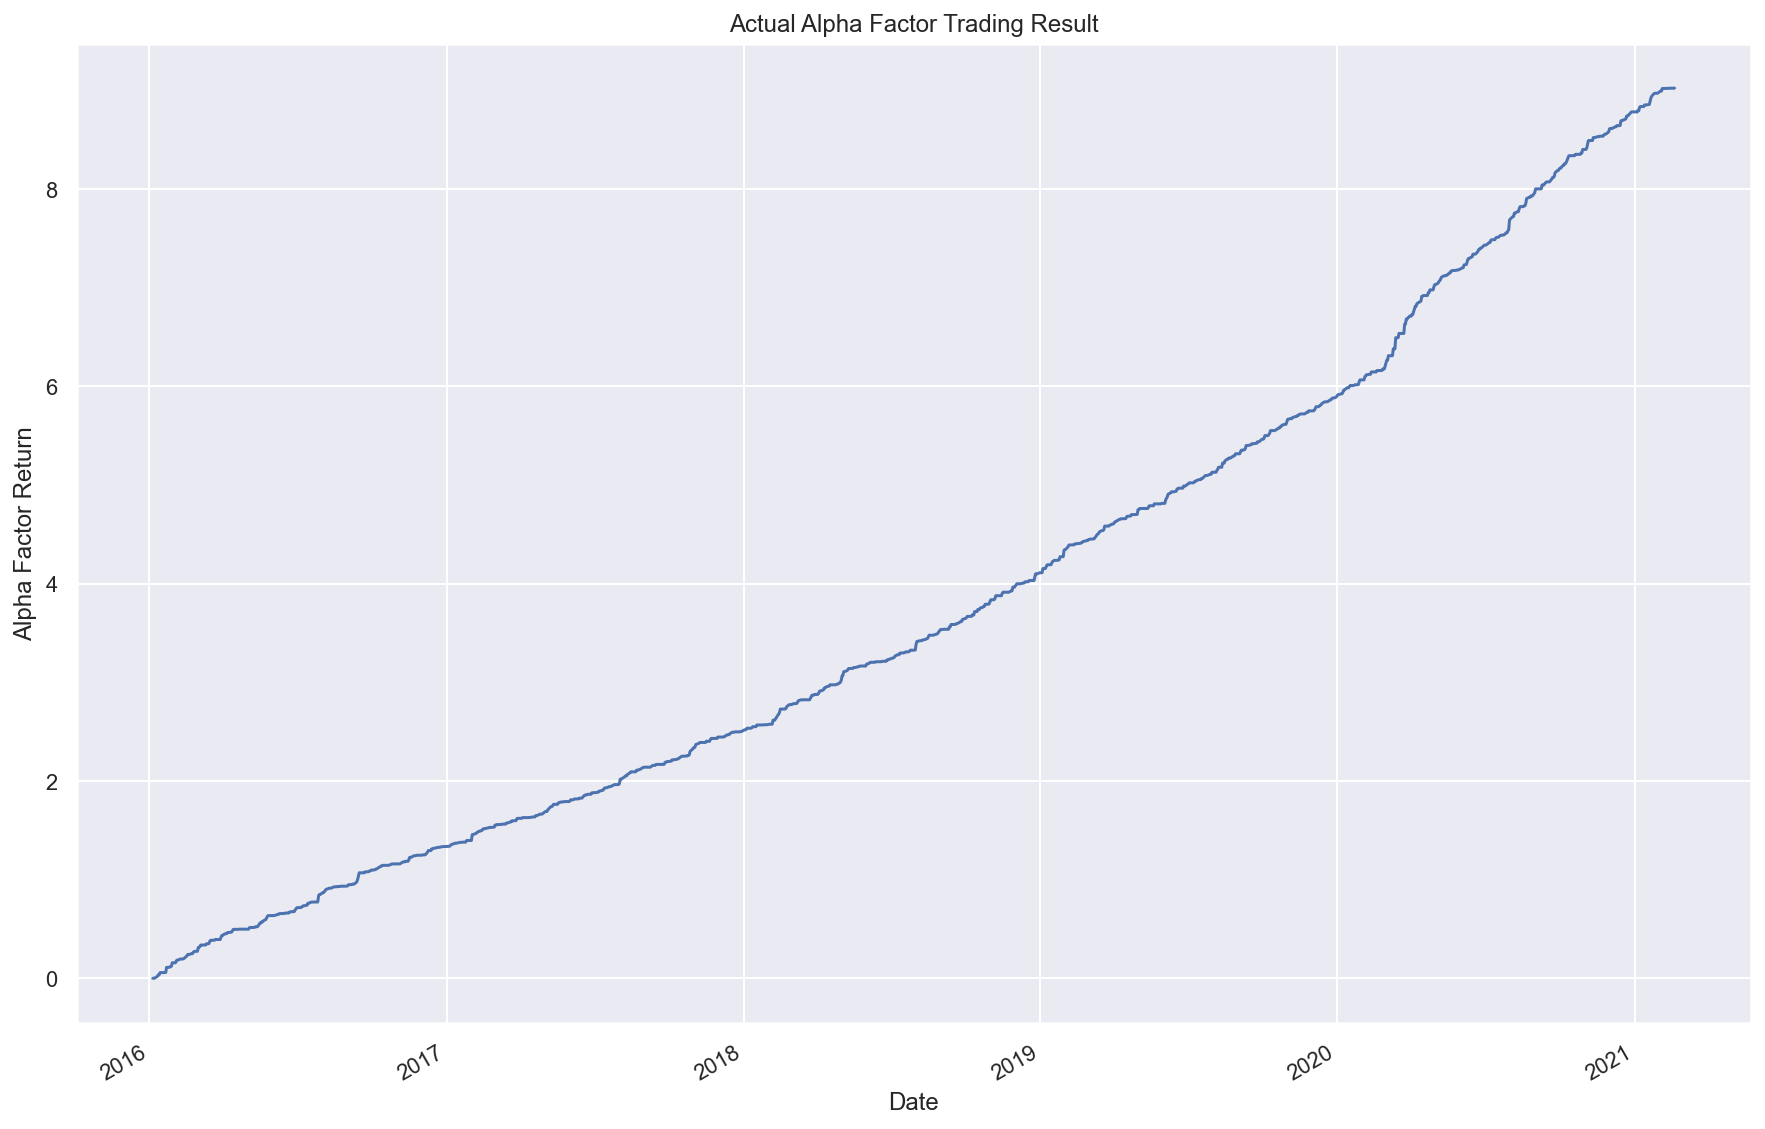

In [11]:
# plot the line of return of using the positive and negative return strategy
data['Actual'] = (data['Return'] * data['Target']).cumsum().plot()
plt.ylabel('Alpha Factor Return')
plt.title('Actual Alpha Factor Trading Result')

## 3-3. Model_1--training data with machine learning mechanism

In [12]:
# using the StandardScaler and support vector mechine
model_1 = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC())])

Text(0.5, 1.0, 'Model_1 Trading Dataset Result')

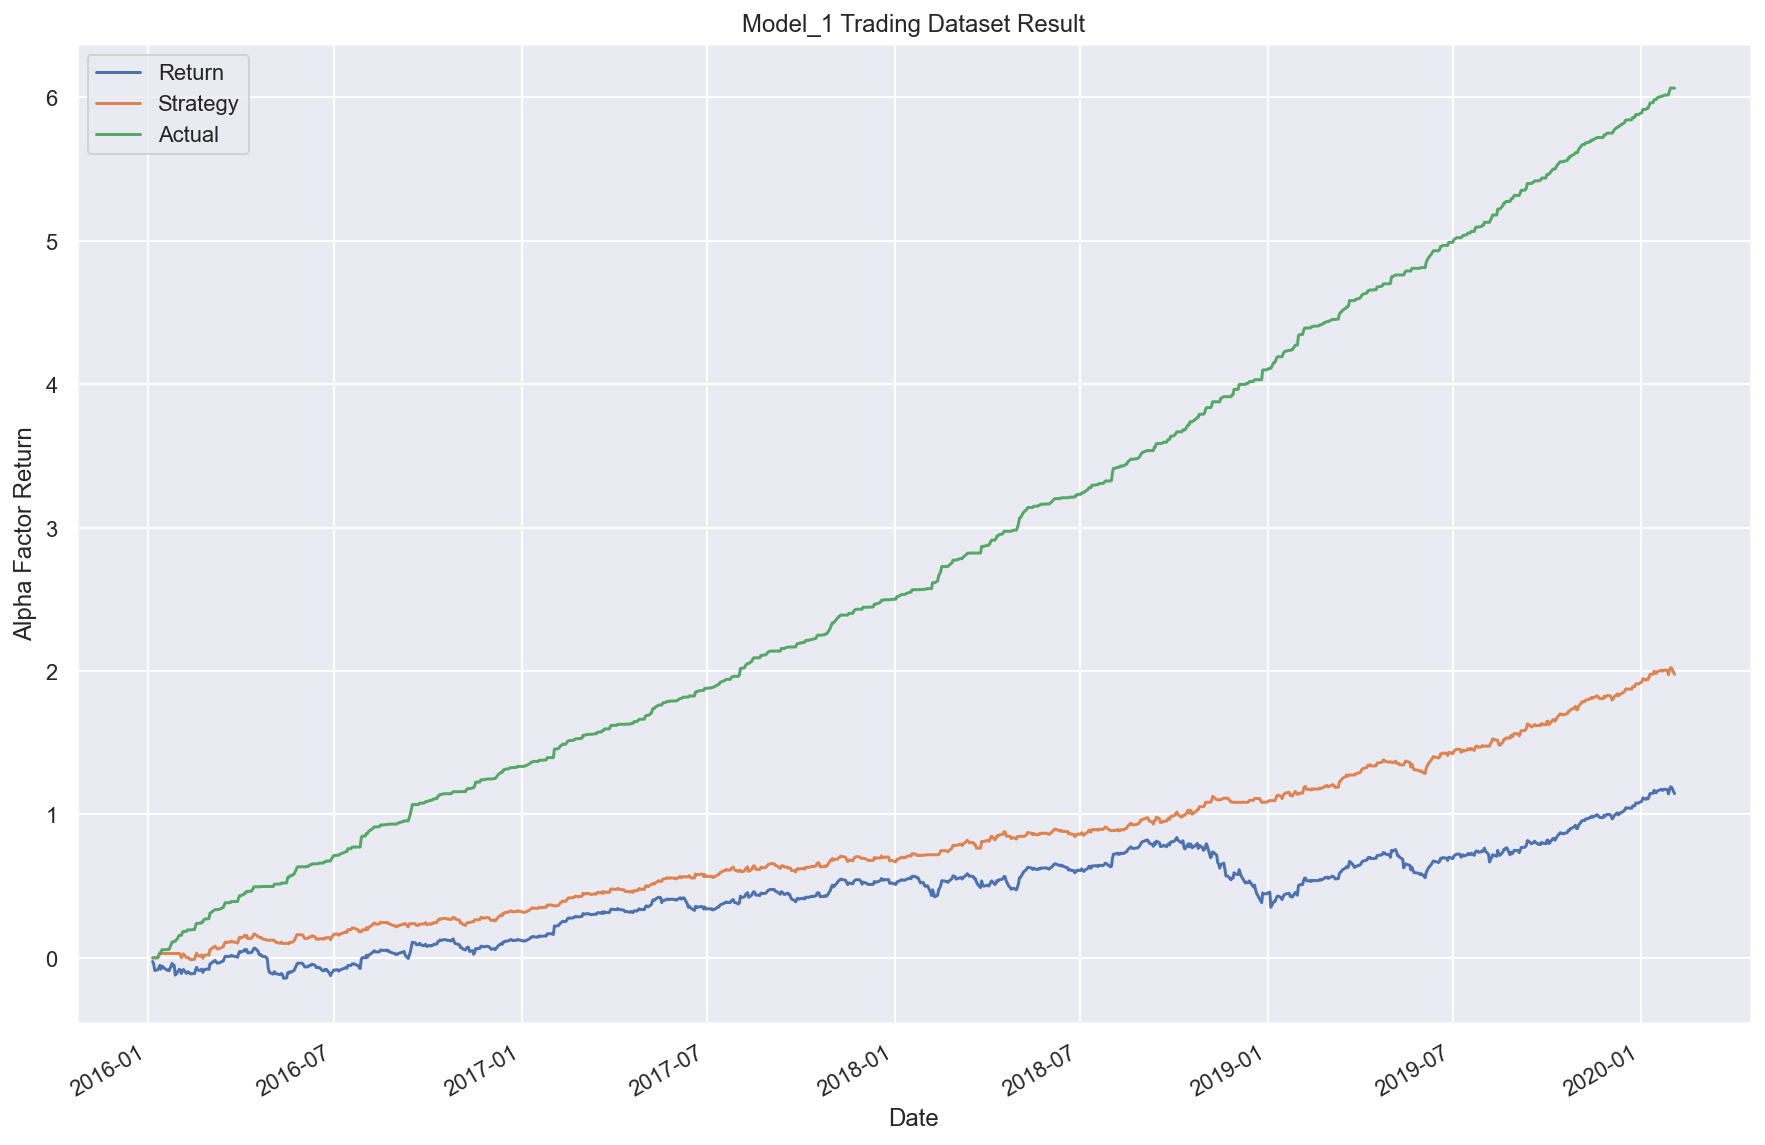

In [13]:
# use the model to fit in X and y 
model_1.fit(X_train, y_train)

# set the predicted and strategy column using alpha factor trading strategy
data_train['Pred'] = model_1.predict(X_train)
data_train['Strategy'] = data_train['Return'] * data_train['Pred']

# plot the return and strategy column
data_train[['Return', 'Strategy']].cumsum().plot()
(data_train['Return'] * data_train['Target']).cumsum().plot(label=r'Actual')
plt.legend()
plt.ylabel('Alpha Factor Return')
plt.title('Model_1 Trading Dataset Result')

### Green line   -->  Actual alpha factor return line
### Blue line      -->  Conventional strategy line
### Orange line -->  Machine learning alpha factor return line

Text(0.5, 1.0, 'Model_1 Testing Dataset Result')

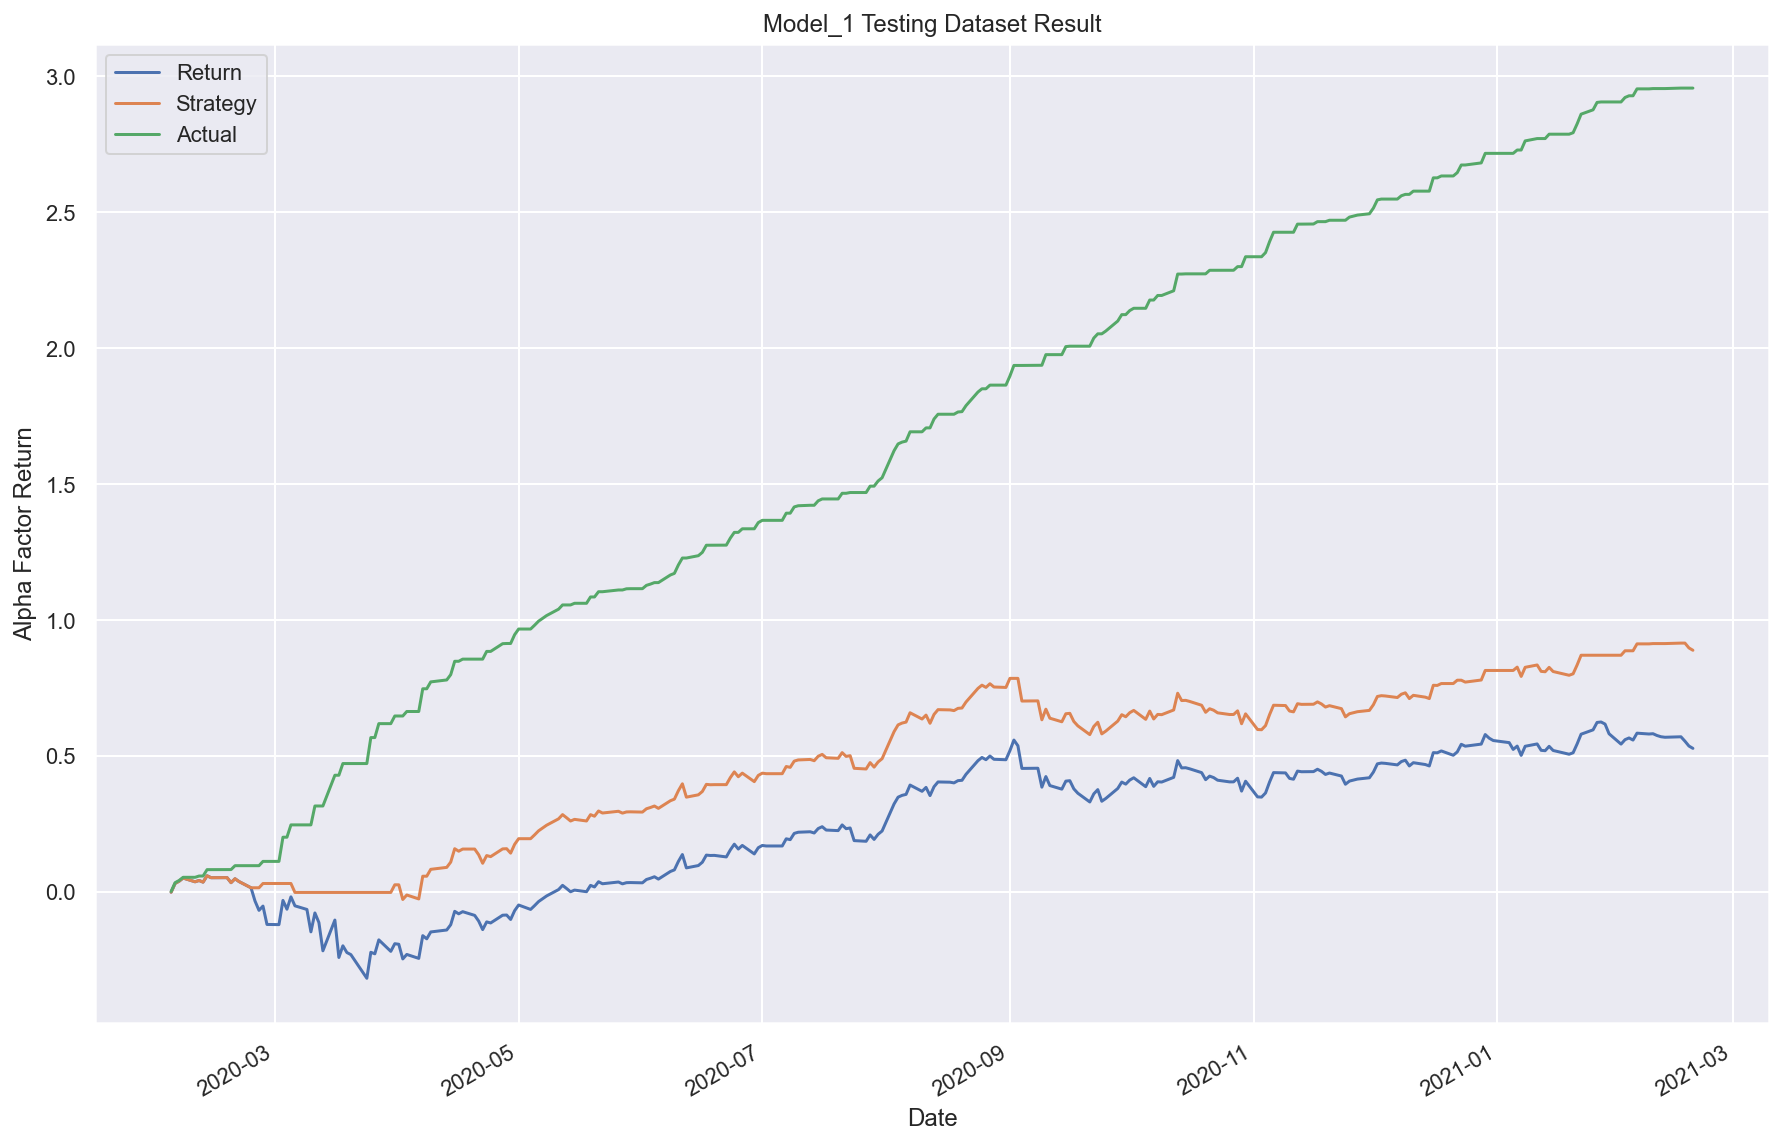

In [14]:
# test the dataset of those after 2020-2-3
model_1.fit(X_test, y_test)

data_test['Pred'] = model_1.predict(X_test)
pred_1 = data_test['Pred']
data_test['Strategy'] = data_test['Return'] * data_test['Pred']

# plot the training result of return and strategy after 2020-2-3
data_test[['Return', 'Strategy']].cumsum().plot()
(data_test['Return'] * data_test['Target']).cumsum().plot(label=r'Actual')
plt.legend()
plt.ylabel('Alpha Factor Return')
plt.title('Model_1 Testing Dataset Result')

In [15]:
# get the mean squared error and R^2 score
print ('RMSE: %0.3f' % mean_squared_error(y_test, pred_1, squared=False))
print ('R^2 Score: %0.3f' % r2_score(y_test, pred_1))

RMSE: 0.619
R^2 Score: -0.536


## 3-4. Model_2--GridSearch in finding the best parameters and train the training dataset

In [16]:
# using GridSearch to test the best parameters of C and gamma
model_1 = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC())])

gs = GridSearchCV(model_1,{
                        'clf__C': np.linspace(1,100),
                        'clf__gamma': np.linspace(1,100)
                        },
                         n_jobs=-1, cv=2)

gs.fit(X_train, y_train)

gs.best_params_

{'clf__C': 93.93877551020407, 'clf__gamma': 1.0}

In [17]:
gs = GridSearchCV(model_1,{
                        'clf__C': np.logspace(0,2),
                        'clf__gamma': np.logspace(0,2)
                        },
                         n_jobs=-1, cv=2)

gs.fit(X_train, y_train)

gs.best_params_

{'clf__C': 68.66488450042998, 'clf__gamma': 1.3257113655901092}

In [18]:
gs = GridSearchCV(model_1,{
                        'clf__C': np.linspace(68.66,93.94),
                        'clf__gamma': np.linspace(1,1.33)
                        },
                         n_jobs=-1, cv=2)

gs.fit(X_train, y_train)

gs.best_params_

{'clf__C': 68.66, 'clf__gamma': 1.289591836734694}

Text(0.5, 1.0, 'Training Dataset Result')

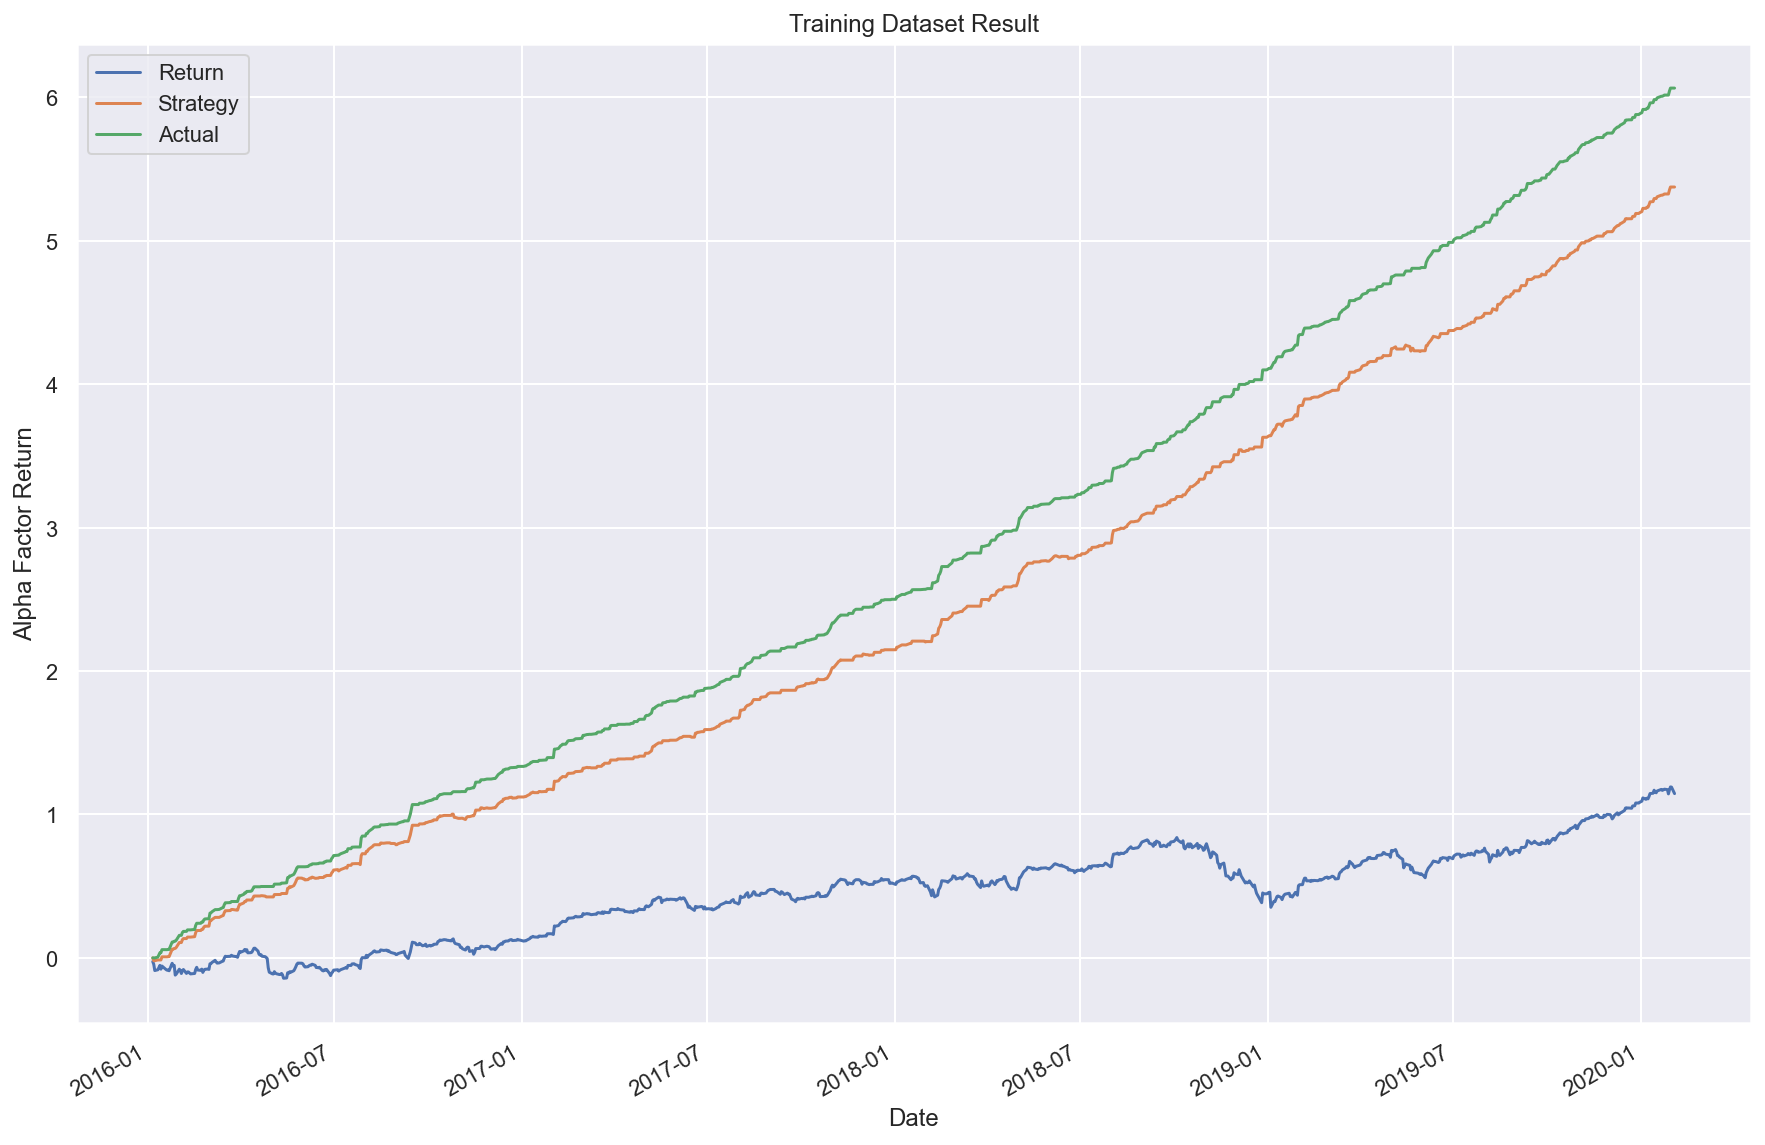

In [19]:
# using the best parameter in to the model
model_2 = Pipeline([('scl', StandardScaler()),
                 ('clf', SVC(C=68.66, gamma=1.29, cache_size=5000))])


model_2.fit(X_train, y_train)

data_train['Pred'] = model_2.predict(X_train)
data_train['Strategy'] = data_train['Return'] * data_train['Pred']
# plot the better model compare to the normal one
data_train[['Return', 'Strategy']].cumsum().plot()
(data_train['Return'] * data_train['Target']).cumsum().plot(label=r'Actual')
plt.legend()
plt.ylabel('Alpha Factor Return')
plt.title('Training Dataset Result')

### 'C' is the hyperparameter of the model and it should be lower down as much as possible to avoid overfitting.
### 'gamma' specifying the degree of curvature of the decision boundary and also should be lower to avoid overfitting

## 4. Test the model-2 with testing dataset and Visualize the results

Text(0.5, 1.0, 'Testing Dataset Result')

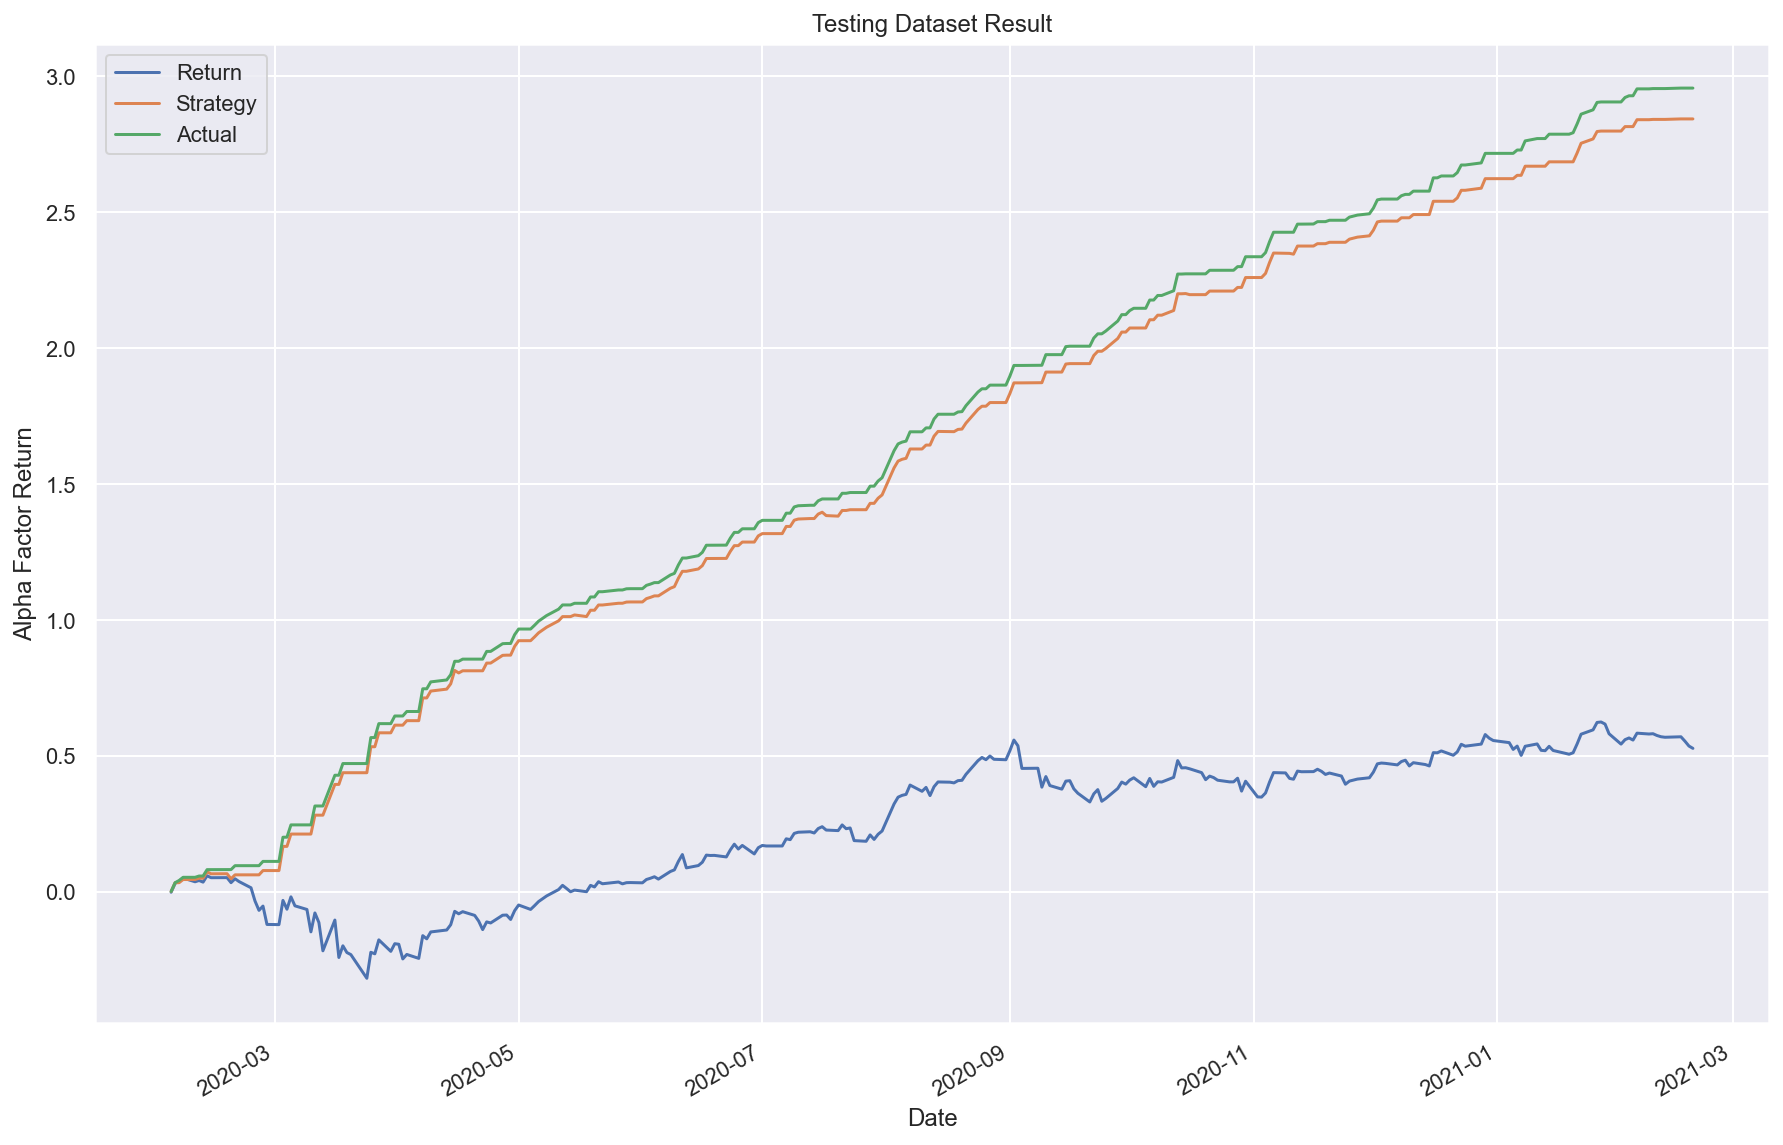

In [20]:
# test the dataset of those after 2020-2-3
model_2.fit(X_test, y_test)

data_test['Pred'] = model_2.predict(X_test)
pred_2 = data_test['Pred']
data_test['Strategy'] = data_test['Return'] * data_test['Pred']

data_test[['Return', 'Strategy']].cumsum().plot()
(data_test['Return'] * data_test['Target']).cumsum().plot(label=r'Actual')
plt.legend()
plt.ylabel('Alpha Factor Return')
plt.title('Testing Dataset Result')

In [21]:
# get the mean squared error and R^2 score
print ('RMSE: %0.3f' % mean_squared_error(y_test, pred_2, squared=False))
print ('R^2 Score: %0.3f' % r2_score(y_test, pred_2))

RMSE: 0.261
R^2 Score: 0.726
